In [7]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()


import sys
sys.path.append('/home/yves/Documents/')  ##append your path to this package
import pGPFA


# Overview


## What it does

This package implements a poisson extension of gaussian process factor analysis (gpfa), which has been sucessfully applied to the analysis of data from motor cortex and other areas. The purpose of the model is to reduce the dimensionality of neural population activity data using plausible assumptions (e.g. that the firing rates of neurons are dependent on common inputs and that)


## Model structure

This model assumes that high dimensional population activity is driven by low-dimensional 'latent states', $\textbf{x}$. Latent states are modelled as gaussian processes ($\mathcal{GP}$) and are thus assumed to vary smoothly (on some timescale, which is inferred from data). Our prior distribution over latent states assumes they are independent, though this rarely holds in the posterior, it simplifies inference. The covariance of the state across timepoints is modelled, and hence the $\mathcal{GP}$ specified by the squared exponential kernel

$K(t_1,t_2) = \sigma_2^2 exp(\frac{- (t_1 -t_2)^2}{2\tau^2}) + \sigma_n^2 $

The firing rates of individual neurons, $\textbf{y}$, in a population linearly couple to these latent states (each neuron can have different 'coupling weights') according to $\textbf{C}$. All neurons also have a baseline firing rate $\textbf{d}$. Conditional on the values of the latent states at each timepoint, firing rates are assumed to be poisson distributed:

$\textbf{y}|\textbf{x} \sim \mathcal{P}(\textbf{y}|exp(\textbf{C}\textbf{x} + \textbf{d})$




In [29]:
nlatentDim = 3
y, params = pGPFA.genSim_data_static(n_neurons=120,
                                     nDims=nlatentDim,
                                     n_timePoints = 80,
                                     nTrials=3,
                                     pretty=False)

### Initialise an Instance of the Model

In [30]:
gpfa = pGPFA.model(data=y,
                   t=params['t'],
                   nDims=nlatentDim,
                   epsNoise=1e-3)

initialised! :)


### Fit the model using EM. 

Note that the use of a laplace approximation for inferring the latent states in the E-step means that the $log(\mathcal{L})$ is not necessarily decreasing after each iteration

In [38]:
gpfa.fit(nIter=10)

Running EM iteration 0 || log(L) after M step is: -1161985.38 ||  total time elapsed: 2.7s
Running EM iteration 1 || log(L) after M step is: -1161988.32 ||  total time elapsed: 5.2s
Running EM iteration 2 || log(L) after M step is: -1161989.34 ||  total time elapsed: 7.8s
Running EM iteration 3 || log(L) after M step is: -1161989.82 ||  total time elapsed: 10.4s
Running EM iteration 4 || log(L) after M step is: -1161990.21 ||  total time elapsed: 13.4s
Running EM iteration 5 || log(L) after M step is: -1161990.18 ||  total time elapsed: 16.5s
Running EM iteration 6 || log(L) after M step is: -1161990.08 ||  total time elapsed: 19.0s
Running EM iteration 7 || log(L) after M step is: -1161990.02 ||  total time elapsed: 22.1s
Running EM iteration 8 || log(L) after M step is: -1161989.82 ||  total time elapsed: 24.6s
Running EM iteration 9 || log(L) after M step is: -1161989.7 ||  total time elapsed: 27.3s


###  Plot the inferred Latent Trajectories

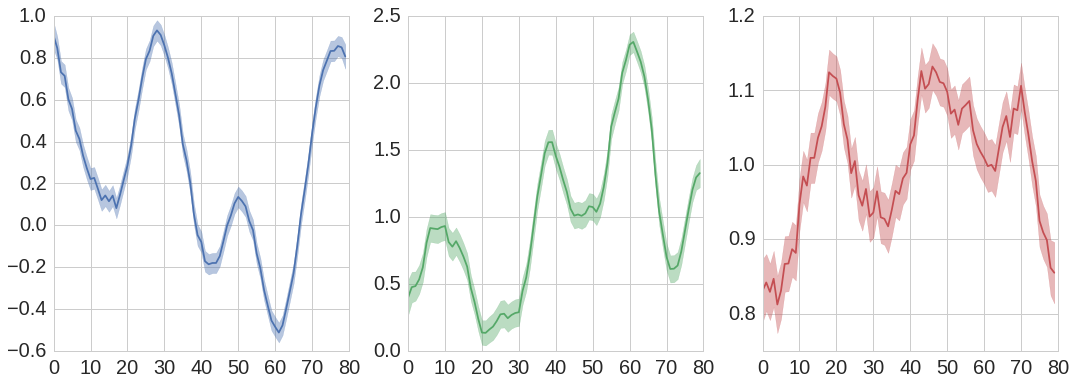

In [39]:
plt.figure(figsize=(18,6))

trl_idx = 0

for i in range(nlatentDim):
    plt.subplot(1,nlatentDim,i+1)
    x = gpfa.params['latent_traj'][trl_idx][i].T
    std2 = 2*np.sqrt(np.diag(gpfa.params['post_cov_GP'][trl_idx][i]))
    plt.plot(x,color=clrs[i])
    plt.fill_between(range(len(gpfa.params['t'])),x-std2, x +std2,color=clrs[i],alpha=.4)

###  To compare to ground truth, compare the z-scored SVD of the true and inferred latent states

In [40]:
#Do the singular value decomposition

U,D,V = np.linalg.svd(gpfa.params['C'])
xSVD = (np.dot(np.diag(D),V.T).dot(gpfa.params['latent_traj'][trl_idx]))

U,D,V = np.linalg.svd(params['C'])
xSVD_true = (np.dot(np.diag(D),V.T).dot(params['latent_traj'][trl_idx]))

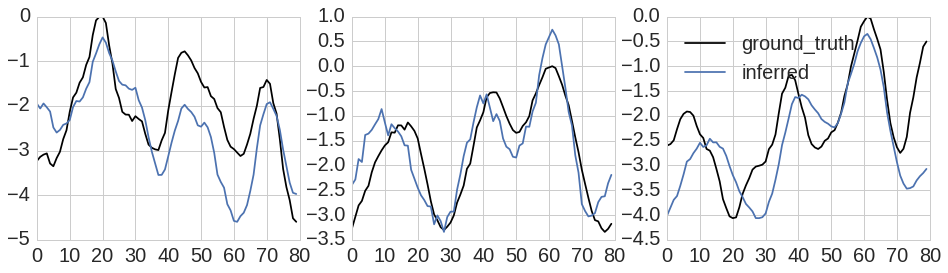

In [41]:
#plot the results
plt.figure(figsize=(16,4))

for i in range(nlatentDim):
    plt.subplot(1,3,i+1)
    zscore_xsvd_true = (xSVD_true[i]-np.max(xSVD_true[i]))/np.std(xSVD_true[i])
    plt.plot(zscore_xsvd_true,'k',label='ground_truth')
    #plt.plot(true_params['latent_traj'][trl][i].T)
    #plt.plot(params['latent_traj'][trl][i].T)
    if np.corrcoef(xSVD_true[i],xSVD[i])[0,1]<0:
        rev = -1
    else:
        rev = 1
    
    zscore_xsvd = rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i])
    offset = np.min(zscore_xsvd_true) - np.min(zscore_xsvd)
    plt.plot(offset + rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i]),label='inferred')
plt.legend(loc='best')

# Plot the Observed, underlying and inferred firing rates of neurons

Note in the plot below, in each panel, the light blue lines are the observed firing rates, the dashed black lines are the underlying (true) firing rates and the orange lines are the inferred firing rates. The vertical black line at the left is a scale bar of 10Hz

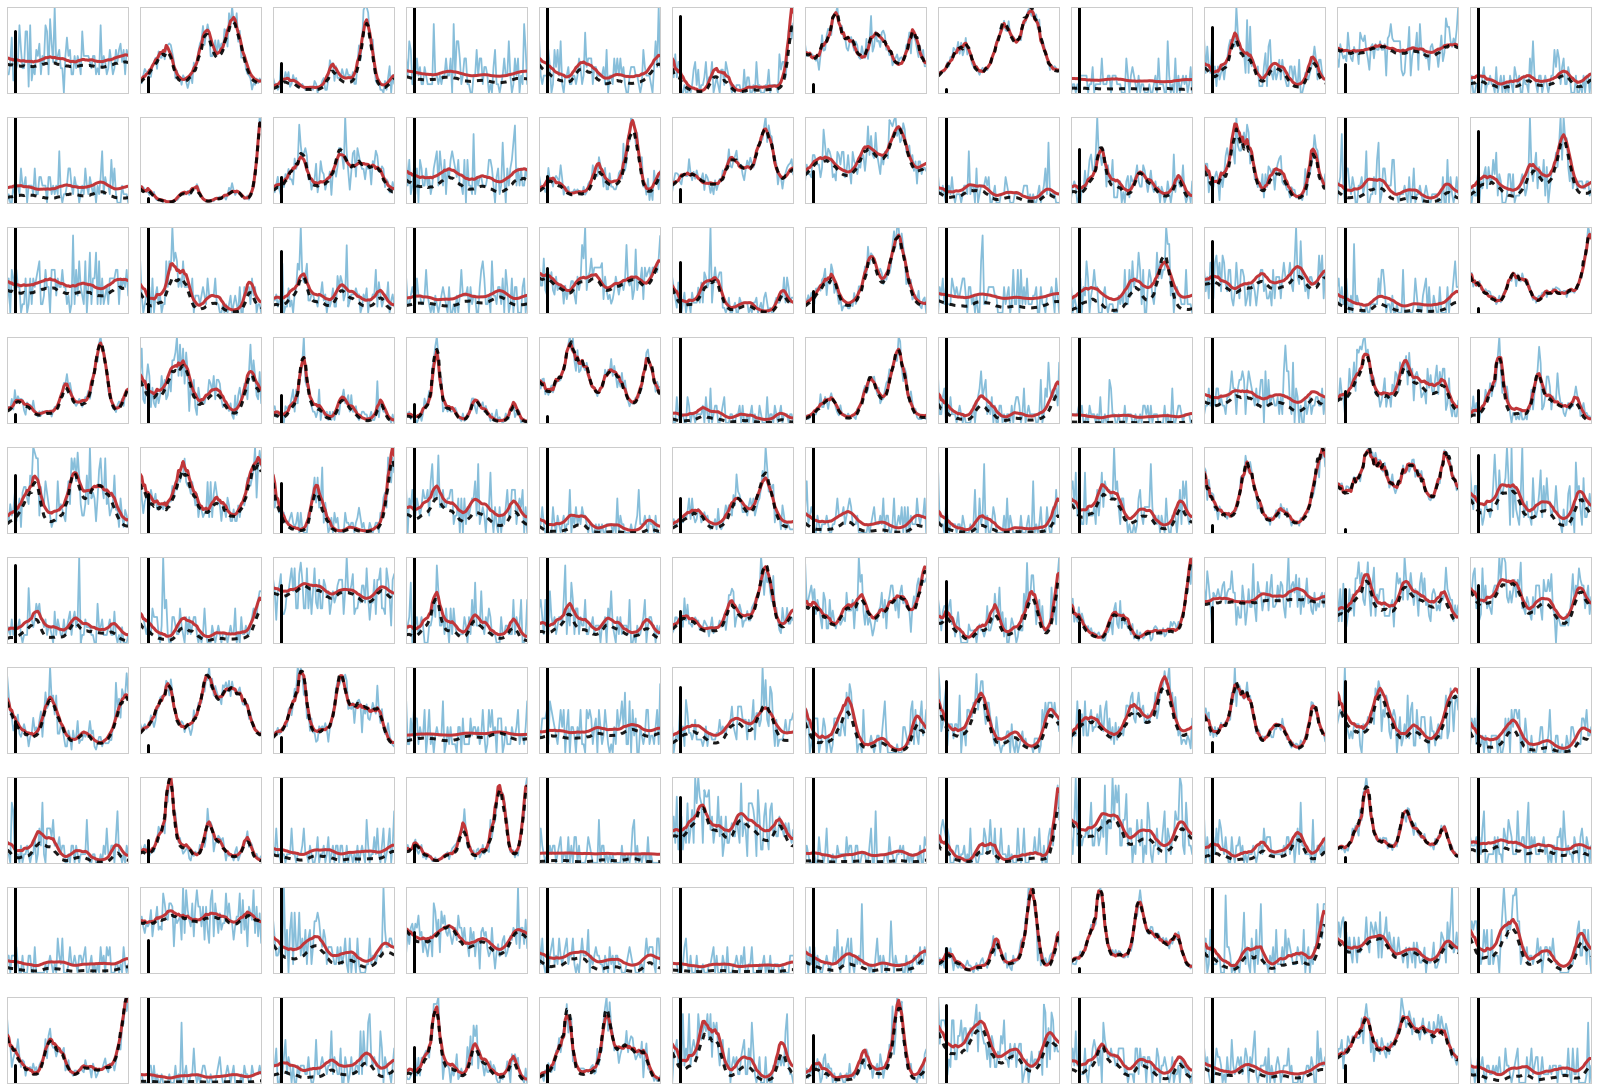

In [43]:
plt.figure(figsize=(22,18))
n_neurons = y[0].shape[0]
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

trl = 0
C = params['C']
x = params['latent_traj']

true_rates = np.exp(params['C'].dot(params['latent_traj'][trl]).T+params['d']).T
inf_rates = np.exp(gpfa.params['C'].dot(gpfa.params['latent_traj'][trl]).T+gpfa.params['d']).T
for real,sim in zip(true_rates,
                    inf_rates):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[trl][tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color='k',linewidth=3,alpha=0.9)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,10],linewidth=3,color='k')
        #plt.ylim()
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)
